In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
import f90nml
from importlib import reload
import sys
sys.path.append('../ice2019')
import retrievestuff as rs
import weibull
import scipy.stats as stats

In [2]:
%matplotlib notebook

In [3]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [11]:
foldername = "Case2.1"; filename = "surface_filtered.txt"

# Load a height file (for synthetic data)
#filename = "surface.txt"

sollast = np.loadtxt(foldername+slash+filename)
Ny, Nx = np.shape(sollast); #print(sollast.shape)
Ntot = np.size(sollast)
print("Nx =", Nx)
print("Ny =", Ny)
print('Npts = ', Ntot)

# Get other parameters
params = f90nml.read(foldername+slash+'parameters.nml')
Lx = params['parameters']['Lx']; print("Lx =", Lx)
Ly = params['parameters']['Ly']; print("Ly =", Ly)

Nx = 41
Ny = 43
Npts =  1763
Lx = 22.678572
Ly = 23.245536299999998


In [12]:
x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny) 
xgrid,ygrid = np.meshgrid(x,y)
dx = x[1]-x[0]
dy = y[1]-y[0]
dzdx = np.diff(sollast, axis=0)/dx
dzdy = np.diff(sollast, axis = 1)/dy #we are not sure which axis is which
Z2 = dzdx[:, 1:]**2+dzdy[1:, :]**2
print(np.shape(Z2))
Z2flat = np.reshape(Z2, (Nx-1)*(Ny-1))
print(np.shape(Z2flat))

(42, 40)
(1680,)


In [13]:
def Weibull(Z2,sigma2W,etaW):
    # Getting the Weibull distribution
    rhoW = etaW/(sigma2W)*(Z2/sigma2W)**(etaW-1)*np.exp(-(Z2/sigma2W)**etaW)
    return rhoW

In [14]:
nbins_max = 14
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says nbins = ', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2max = .04
Z2bins = np.linspace(0,Z2max,nbins-1)
counts, bins, meanZ2, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=2)
if (len(np.argwhere(counts==0)) != 0):
    print('!!!!!!!!')
    print('Need to make Z2max smaller')

Sturges rule says nbins =  11
Using nbins =  11
Original =  1680
3 0 560 [242 139  68  44  17  21   5   6   6]
3 1 560 [245 135  57  53  29  13   9   6   5]
3 2 560 [238 139  75  41  24  14   7  10   3]
ilevelp = 3
ilevelp, t = 3 3.18244630528


In [15]:
# Normalizes the experimental distribution function
print('mean Z2 = ', np.mean(Z2))
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho

mean Z2 =  0.00854862981908
integral =  0.00344976108756


<IPython.core.display.Javascript object>


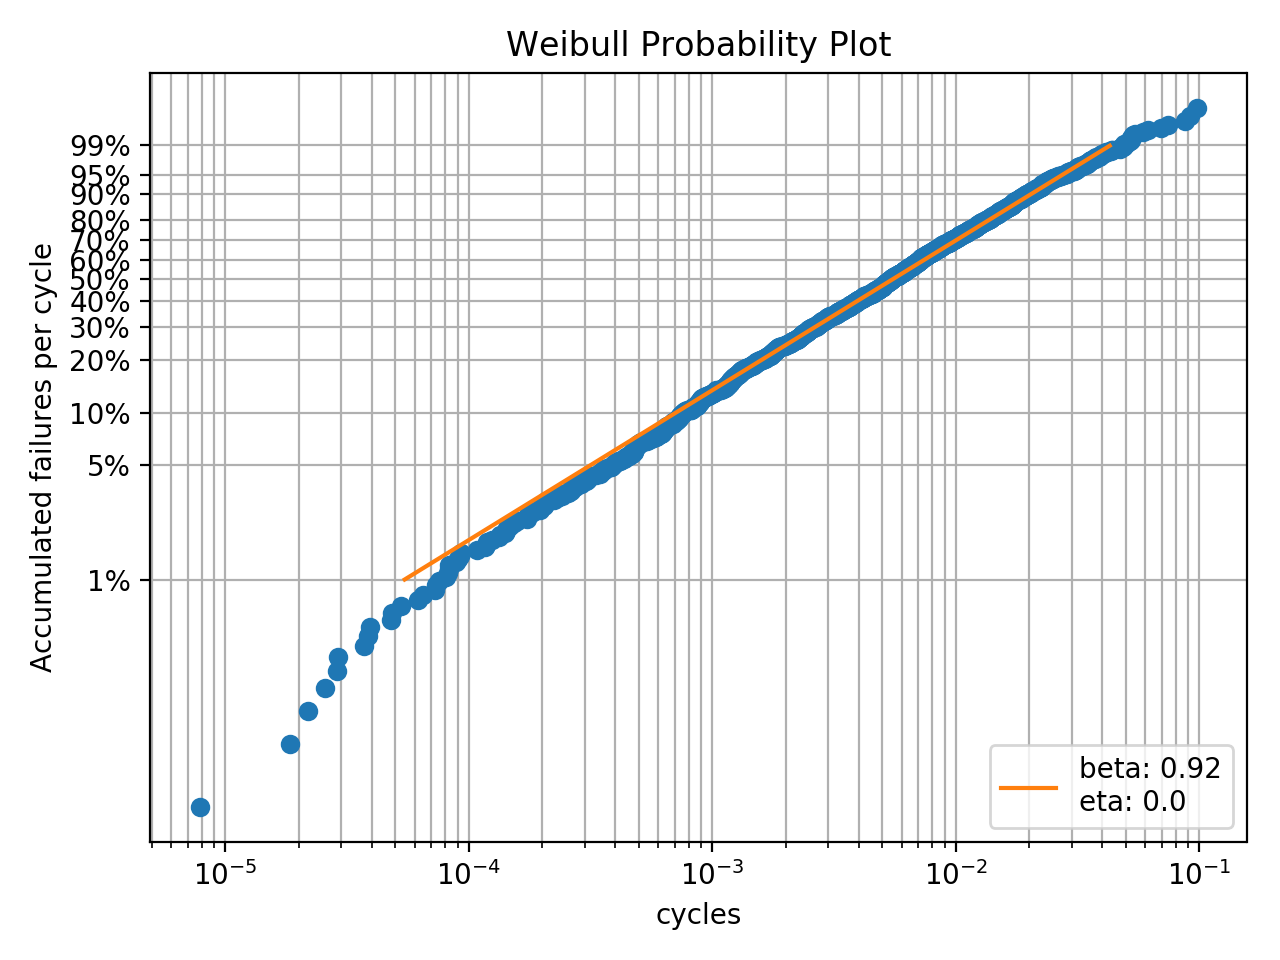

fit method          maximum likelihood estimation
confidence                                    0.9
beta lower limit                          0.88793
beta nominal                             0.915613
beta upper limit                          0.94416
eta lower limit                        0.00781624
eta nominal                            0.00818602
eta upper limit                        0.00857331
mean life                               0.0085342
median life                            0.00548565
b10 life                              0.000700934
dtype: object
etaW =  0.915613276971
sigmaW= 0.0904766502234


In [21]:
#does weibull analysis on experimental data
analysis = weibull.Analysis(Z2flat)
analysis.fit(method='mle')
plt.figure()
analysis.probplot()
print(analysis.stats)
etaW = analysis.beta
sigma2W = analysis.eta
sigmaW = np.sqrt(sigma2W)
print('etaW = ', etaW)
print('sigmaW=', sigmaW)

# These numbers need to be extracted from the weibull fitting routine




<IPython.core.display.Javascript object>


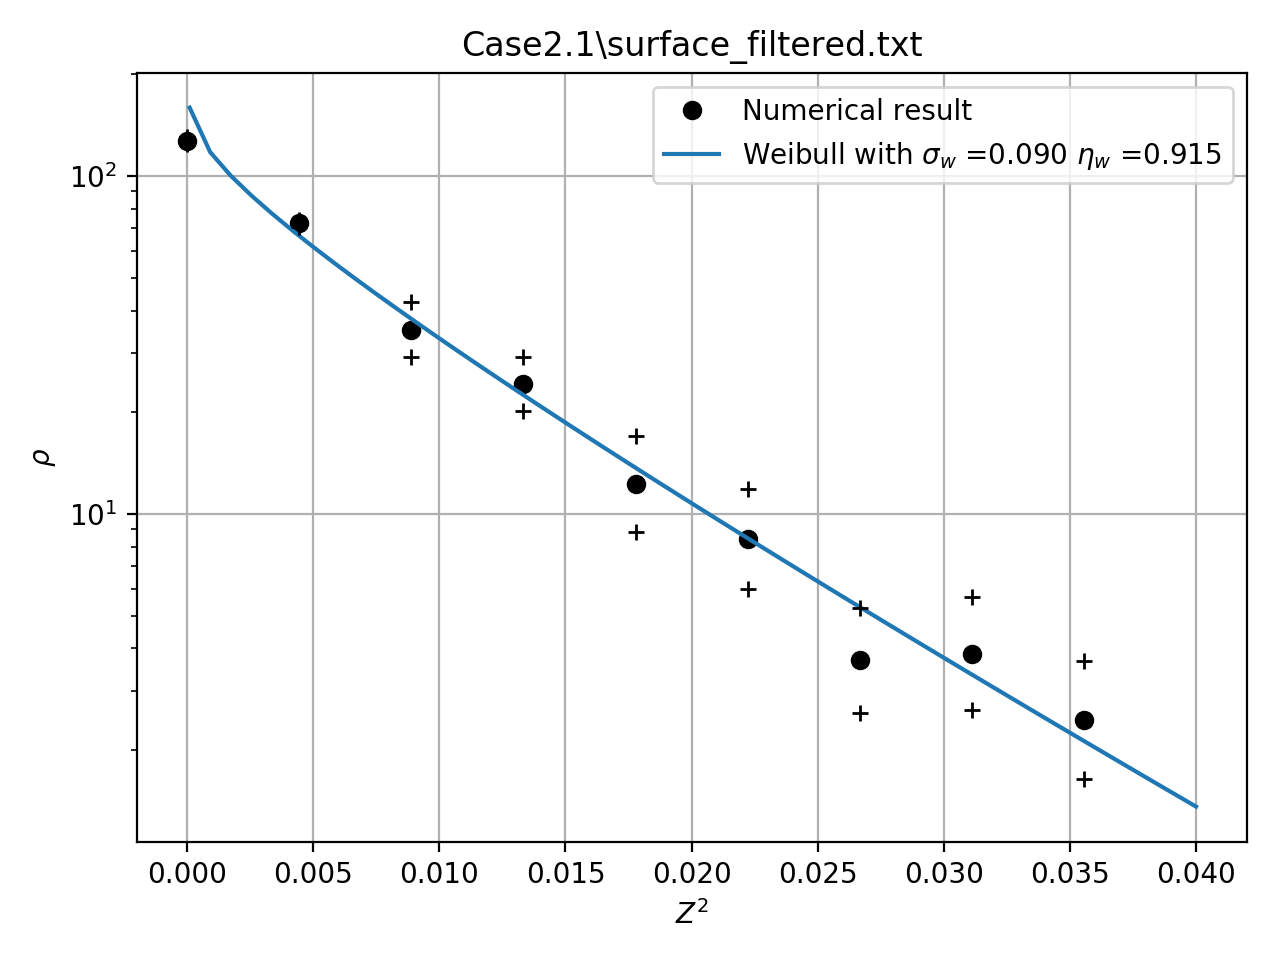

[ 127.29223566   72.51268045   35.11509949   24.22941865   12.29028482
    8.42762388    3.68708545    3.86266094    2.45805696]
[ 130.06734581   74.33758164   42.28524286   29.16424976   17.05341676
   11.87204934    5.26749624    5.68756213    3.66511564]
[ 124.57633512   70.73257847   29.16076931   20.12960158    8.85752709
    5.98252603    2.58084647    2.62329434    1.64852753]


Text(0.5,1,'Case2.1\\surface_filtered.txt')

In [26]:
# Graph the experimental distribution function
fig = plt.figure()
plt.semilogy(bins, counts, 'ok', label='Numerical result')

# Graph the best-fit distribution function
Z2 = np.linspace(0.0001,Z2max,50)
myWeibull = Weibull(Z2,sigma2W,etaW)
plt.semilogy(Z2, myWeibull, label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
plt.grid(True)
plt.legend()

# Graphing the error bars (sloppily)
print(counts)
countsplus = counts+error; print(countsplus)
countsminus = counts**2/countsplus; print(countsminus)
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k') 

# Cosmetics
plt.grid(True)
plt.xlabel('$Z^2$')
plt.ylabel(r'$\rho$')
plt.title(foldername+slash+filename)

